<a href="https://colab.research.google.com/github/sandiridwan1/DLC/blob/main/ADL08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install d2l

  Using cached matplotlib-3.3.3-cp37-cp37m-manylinux1_x86_64.whl (11.6 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.0.2
    Uninstalling matplotlib-3.0.2:
      Successfully uninstalled matplotlib-3.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
!pip install matplotlib==3.0.2

  Using cached matplotlib-3.0.2-cp37-cp37m-manylinux1_x86_64.whl (12.9 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.3
    Uninstalling matplotlib-3.3.3:
      Successfully uninstalled matplotlib-3.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plotnine 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.2 which is incompatible.
mizani 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.2 which is incompatible.
d2l 0.17.3 requires matplotlib==3.3.3, but you have matplotlib 3.0.2 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


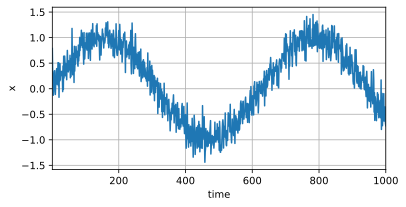

In [ ]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

T = 1000  # Generate a total of 1000 points
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [ ]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
# Only the first `n_train` examples are used for training
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

In [ ]:
# Function for initializing the weights of the network
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# A simple MLP
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# Note: `MSELoss` computes squared error without the 1/2 factor
loss = nn.MSELoss(reduction='none')

In [ ]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.071466
epoch 2, loss: 0.052073
epoch 3, loss: 0.049622
epoch 4, loss: 0.049348
epoch 5, loss: 0.048743


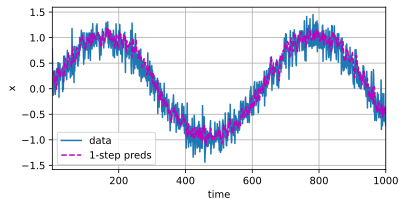

In [ ]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]], [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3))

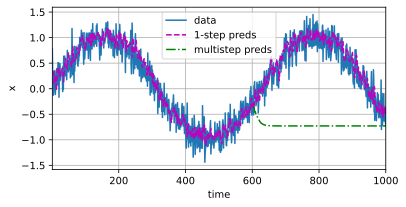

In [ ]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

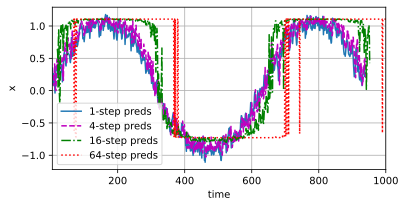

In [ ]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# Column `i` (`i` < `tau`) are observations from `x` for time steps from
# `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# Column `i` (`i` >= `tau`) are the (`i - tau + 1`)-step-ahead predictions for
# time steps from `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))

In [ ]:
import collections
import re
from d2l import torch as d2l

In [ ]:

d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt',
                                '090b5e7e70c295757f55df93cb0a180b9691891a')

def read_time_machine():  
    """Load the time machine dataset into a list of text lines."""
    with open(d2l.download('time_machine'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

lines = read_time_machine()
print(f'# text lines: {len(lines)}')
print(lines[0])
print(lines[10])

# text lines: 3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


In [ ]:
def tokenize(lines, token='word'): 
    """Split text lines into word or character tokens."""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('ERROR: unknown token type: ' + token)

tokens = tokenize(lines)
for i in range(11):
    print(tokens[i])

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']


In [ ]:
class Vocab: 
    """Vocabulary for text."""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # Sort according to frequencies
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # The index for the unknown token is 0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # Index for the unknown token
        return 0

    @property
    def token_freqs(self):  # Index for the unknown token
        return self._token_freqs

def count_corpus(tokens):  
    """Count token frequencies."""
    # Here `tokens` is a 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flatten a list of token lists into a list of tokens
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [ ]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]


In [ ]:
for i in [0, 10]:
    print('words:', tokens[i])
    print('indices:', vocab[tokens[i]])

words: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
indices: [1, 19, 50, 40, 2183, 2184, 400]
words: ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
indices: [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]


In [ ]:
def load_corpus_time_machine(max_tokens=-1):  
    """Return token indices and the vocabulary of the time machine dataset."""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # Since each text line in the time machine dataset is not necessarily a
    # sentence or a paragraph, flatten all the text lines into a single list
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)

(170580, 28)

In [ ]:
import random
import torch
from d2l import torch as d2l

tokens = d2l.tokenize(d2l.read_time_machine())
# Since each text line is not necessarily a sentence or a paragraph, we
# concatenate all text lines
corpus = [token for line in tokens for token in line]
vocab = d2l.Vocab(corpus)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

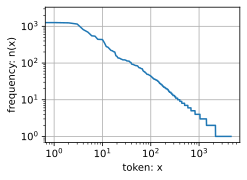

In [ ]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)',
         xscale='log', yscale='log')

In [ ]:
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = d2l.Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

In [ ]:
trigram_tokens = [triple for triple in zip(
    corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = d2l.Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

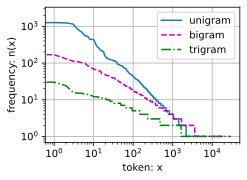

In [ ]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])

In [ ]:
def seq_data_iter_random(corpus, batch_size, num_steps):  
    """Generate a minibatch of subsequences using random sampling."""
    # Start with a random offset (inclusive of `num_steps - 1`) to partition a
    # sequence
    corpus = corpus[random.randint(0, num_steps - 1):]
    # Subtract 1 since we need to account for labels
    num_subseqs = (len(corpus) - 1) // num_steps
    # The starting indices for subsequences of length `num_steps`
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # In random sampling, the subsequences from two adjacent random
    # minibatches during iteration are not necessarily adjacent on the
    # original sequence
    random.shuffle(initial_indices)

    def data(pos):
        # Return a sequence of length `num_steps` starting from `pos`
        return corpus[pos: pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # Here, `initial_indices` contains randomized starting indices for
        # subsequences
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

In [ ]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[25, 26, 27, 28, 29],
        [20, 21, 22, 23, 24]]) 
Y: tensor([[26, 27, 28, 29, 30],
        [21, 22, 23, 24, 25]])
X:  tensor([[ 0,  1,  2,  3,  4],
        [15, 16, 17, 18, 19]]) 
Y: tensor([[ 1,  2,  3,  4,  5],
        [16, 17, 18, 19, 20]])
X:  tensor([[10, 11, 12, 13, 14],
        [ 5,  6,  7,  8,  9]]) 
Y: tensor([[11, 12, 13, 14, 15],
        [ 6,  7,  8,  9, 10]])


In [ ]:
def seq_data_iter_sequential(corpus, batch_size, num_steps):  
    """Generate a minibatch of subsequences using sequential partitioning."""
    # Start with a random offset to partition a sequence
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

In [ ]:
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 3,  4,  5,  6,  7],
        [18, 19, 20, 21, 22]]) 
Y: tensor([[ 4,  5,  6,  7,  8],
        [19, 20, 21, 22, 23]])
X:  tensor([[ 8,  9, 10, 11, 12],
        [23, 24, 25, 26, 27]]) 
Y: tensor([[ 9, 10, 11, 12, 13],
        [24, 25, 26, 27, 28]])
X:  tensor([[13, 14, 15, 16, 17],
        [28, 29, 30, 31, 32]]) 
Y: tensor([[14, 15, 16, 17, 18],
        [29, 30, 31, 32, 33]])


In [ ]:
class SeqDataLoader:  
    """An iterator to load sequence data."""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_sequential
        self.corpus, self.vocab = d2l.load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

In [ ]:
def load_data_time_machine(batch_size, num_steps,  
                           use_random_iter=False, max_tokens=10000):
    """Return the iterator and the vocabulary of the time machine dataset."""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

In [ ]:
import torch
from d2l import torch as d2l

X, W_xh = torch.normal(0, 1, (3, 1)), torch.normal(0, 1, (1, 4))
H, W_hh = torch.normal(0, 1, (3, 4)), torch.normal(0, 1, (4, 4))
torch.matmul(X, W_xh) + torch.matmul(H, W_hh)

tensor([[-1.2478,  1.0376, -0.6593, -0.4783],
        [-0.3401,  1.6080,  1.2299,  3.4457],
        [-0.3879, -2.1384,  0.3632, -2.2748]])

In [ ]:
torch.matmul(torch.cat((X, H), 1), torch.cat((W_xh, W_hh), 0))

tensor([[-1.2478,  1.0376, -0.6593, -0.4783],
        [-0.3401,  1.6080,  1.2299,  3.4457],
        [-0.3879, -2.1384,  0.3632, -2.2748]])

In [ ]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [ ]:
F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [ ]:
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

In [ ]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # Hidden layer parameters
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # Attach gradients
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [ ]:
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

In [ ]:
def rnn(inputs, state, params):
    # Here `inputs` shape: (`num_steps`, `batch_size`, `vocab_size`)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # Shape of `X`: (`batch_size`, `vocab_size`)
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

In [ ]:
class RNNModelScratch: 
    """A RNN Model implemented from scratch."""
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [ ]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

In [ ]:
def predict_ch8(prefix, num_preds, net, vocab, device):  
    """Generate new characters following the `prefix`."""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:  # Warm-up period
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # Predict `num_preds` steps
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [ ]:
predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())

'time traveller xc<unk>wwxk<unk>zf'

In [ ]:
def grad_clipping(net, theta):  
    """Clip the gradient."""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [ ]:

def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """Train a net within one epoch (defined in Chapter 8)."""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # Initialize `state` when either it is the first iteration or
            # using random sampling
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # `state` is a tensor for `nn.GRU`
                state.detach_()
            else:
                # `state` is a tuple of tensors for `nn.LSTM` and
                # for our custom scratch implementation
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # Since the `mean` function has been invoked
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [ ]:

def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """Train a model (defined in Chapter 8)."""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # Initialize
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # Train and predict
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'perplexity {ppl:.1f}, {speed:.1f} tokens/sec on {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

perplexity 1.0, 20440.2 tokens/sec on cpu
time traveller for so it will be convenient to speak of himwas e
traveller with a slight accession ofcheerfulness really thi


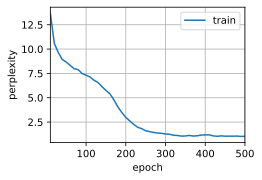

In [ ]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

perplexity 1.4, 19962.1 tokens/sec on cpu
time traveller smiled roubeilareqly dey ha rilen atways have don
traveller smiled roubeingt tons vealt itseet monens on so a


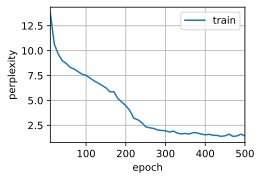

In [ ]:
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),
          use_random_iter=True)

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [ ]:
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)

In [ ]:
state = torch.zeros((1, batch_size, num_hiddens))
state.shape

torch.Size([1, 32, 256])

In [ ]:
X = torch.rand(size=(num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
Y.shape, state_new.shape

(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

In [ ]:

class RNNModel(nn.Module):
    """The RNN model."""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        # If the RNN is bidirectional (to be introduced later),
        # `num_directions` should be 2, else it should be 1.
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # The fully connected layer will first change the shape of `Y` to
        # (`num_steps` * `batch_size`, `num_hiddens`). Its output shape is
        # (`num_steps` * `batch_size`, `vocab_size`).
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # `nn.GRU` takes a tensor as hidden state
            return  torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device)
        else:
            # `nn.LSTM` takes a tuple of hidden states
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))

In [ ]:
device = d2l.try_gpu()
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
d2l.predict_ch8('time traveller', 10, net, vocab, device)

'time travellerzzznznznzn'

perplexity 1.3, 61969.4 tokens/sec on cpu
time traveller held in his hand wa sam sthe gethe focer praceote
traveller cathom his reat fighided fil sam there are balloo


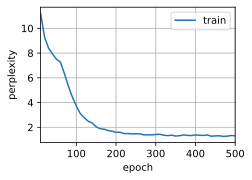

In [ ]:
num_epochs, lr = 500, 1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, device)